# Generate the master syn.phot table
- Gregory S.H. Paek
- 22.09.28
- 22.11.09
- Tables contain the syn.phot information for transients' spectrum
	- m400, ..., m875
	- ugriz
	- BVRI


In [179]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
#	astropy
from astropy.io import ascii
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, vstack, hstack
#	speclite
import speclite.filters
import speclite.redshift

In [180]:
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [181]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
medfilterlist = bdwtbl['filter'][bdwtbl['group']=='Med']

from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
sdssfilterlist = bdwtbl['filter'][bdwtbl['group']=='SDSS']

from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
jcfilterlist = bdwtbl['filter'][bdwtbl['group']=='Johnson Cousin']

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()
lsstfilterlist = np.array(['u', 'g', 'r', 'i', 'z', 'y'])

In [182]:
xl, xr = 3000, 10000 # [A]

In [183]:
#	Kilonova Cube Table
kncbtbl[:3]

number,model,shape,latitude,md,vd,mw,vw,type
int64,bytes81,bytes9,bytes5,float64,float64,float64,float64,bytes4
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_spec_2020-03-19.fits,toroidal,Axial,0.001,0.05,0.001,0.05,spec
1,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.15_spec_2020-05-24.fits,toroidal,Axial,0.001,0.05,0.001,0.15,spec
2,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.3_spec_2020-03-10.fits,toroidal,Axial,0.001,0.05,0.001,0.3,spec


- select the kilonova model

In [184]:
kk = 0
#	Single KN spectrum Table
knsp = f"../3.table/kn_sim_cube_lite/{kncbtbl['model'][kk]}"
knsp
knsptbl = Table.read(knsp)
knsptbl[:5]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,lam
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1e-05,1.0047e-05,0.00010256,0.000101585,9.9135e-05,9.46562e-05,8.98205e-05,8.69291e-05,8.63167e-05,8.02315e-05,7.88266e-05,7.35116e-05,7.13724e-05,6.79792e-05,6.46325e-05,6.12394e-05,6.22092e-05,5.79724e-05,5.62445e-05,5.34613e-05,5.06864e-05,4.67779e-05,4.84974e-05,4.75032e-05,4.29607e-05,4.61508e-05,4.39938e-05,4.38748e-05,4.45292e-05,4.31402e-05,4.42695e-05,4.6581e-05,4.7525e-05,4.89333e-05,4.76984e-05,5.42631e-05,5.41489e-05,5.81661e-05,6.12681e-05,6.22359e-05,6.66985e-05,7.31607e-05,7.33298e-05,8.10351e-05,8.09365e-05,8.47781e-05,9.07023e-05,9.48351e-05,0.000100745,0.000108601,0.00011159,0.000115585,0.000116081,0.000126272,0.000126636,0.000134352,1002.35
1.0047e-05,1.0095e-05,5.28218e-06,5.73466e-06,5.36856e-06,5.57242e-06,4.66126e-06,4.55073e-06,4.35625e-06,3.82455e-06,4.33313e-06,4.12498e-06,4.46257e-06,4.75926e-06,4.76098e-06,4.89447e-06,4.27125e-06,4.92262e-06,4.86734e-06,4.95018e-06,4.54557e-06,5.20319e-06,4.65838e-06,4.80353e-06,4.35931e-06,4.11856e-06,4.61903e-06,4.10897e-06,4.84308e-06,4.31281e-06,4.16278e-06,4.32886e-06,5.21894e-06,4.79846e-06,4.02185e-06,3.95936e-06,4.56844e-06,4.43789e-06,4.84239e-06,4.38438e-06,4.62042e-06,4.70652e-06,4.05975e-06,4.62711e-06,4.53284e-06,3.54355e-06,4.20283e-06,3.85781e-06,4.23939e-06,4.66695e-06,5.11748e-06,5.03424e-06,5.22645e-06,5.26499e-06,5.31354e-06,5.51217e-06,1007.1
1.0095e-05,1.0143e-05,5.68171e-06,6.00535e-06,5.76423e-06,5.13588e-06,5.45709e-06,5.40467e-06,5.09933e-06,4.8766e-06,4.29302e-06,4.8259e-06,4.35215e-06,4.34118e-06,4.69808e-06,4.51673e-06,4.87534e-06,5.02454e-06,4.28168e-06,4.25561e-06,4.46502e-06,4.48748e-06,4.33525e-06,4.34474e-06,4.40536e-06,3.88943e-06,4.25018e-06,3.96067e-06,3.87034e-06,4.13599e-06,3.89785e-06,4.52917e-06,3.43709e-06,4.45497e-06,3.95719e-06,4.14685e-06,3.89669e-06,4.45014e-06,4.183e-06,4.58354e-06,5.52662e-06,4.33171e-06,5.31888e-06,3.93982e-06,4.29983e-06,4.88932e-06,4.71703e-06,4.39679e-06,4.92096e-06,5.3859e-06,5.52855e-06,5.63539e-06,6.29636e-06,5.8366e-06,6.48582e-06,6.23448e-06,1011.8999999999999
1.0143e-05,1.0191e-05,7.42547e-06,6.77337e-06,6.28805e-06,6.80327e-06,6.02362e-06,5.66615e-06,5.47925e-06,5.22189e-06,4.86947e-06,4.44316e-06,5.1253e-06,5.23829e-06,5.34105e-06,4.43748e-06,4.84375e-06,3.78838e-06,4.26152e-06,4.11598e-06,3.96635e-06,4.05318e-06,4.21133e-06,4.10965e-06,4.4523e-06,3.6048e-06,4.40931e-06,4.17248e-06,3.79943e-06,3.45154e-06,3.51532e-06,3.49874e-06,3.67555e-06,4.27289e-06,4.37201e-06,3.85552e-06,4.07497e-06,3.86321e-06,4.28625e-06,4.65889e-06,4.47484e-06,4.88204e-06,4.7766e-06,4.90515e-06,5.02166e-06,4.77279e-06,5.28095e-06,5.51054e-06,5.68241e-06,6.36458e-06,6.21407e-06,6.10488e-06,6.04264e-06,6.33165e-06,7.04701e-06,6.88077e-06,1016.6999999999999
1.0191e-05,1.024e-05,6.98161e-06,6.93879e-06,6.66278e-06,6.30314e-06,6.1115e-06,5.78465e-06,5.61972e-06,5.13506e-06,5.93683e-06,5.58654e-06,5.20813e-06,5.42461e-06,4.9499e-06,4.4657e-06,4.30258e-06,3.96758e-06,4.13614e-06,4.25728e-06,4.49594e-06,4.49344e-06,3.63952e-06,3.70821e-06,3.77432e-06,3.43393e-06,3.40739e-06,2.90638e-06,3.37206e-06,3.68753e-06,3.66063e-06,3.48635e-06,3.00994e-06,3.54209e-06,3.69449e-06,3.91321e-06,3.82549e-06,4.22616e-06,3.74485e-06,4.73395e-06,4.03413e-06,4.62528e-06,4.

- select angle

In [185]:
#	All angles
angles =[f'col{n}' for n in np.arange(3, 56+1, 1)]
magoffset = -2.5*np.log10(len(angles))
anglesize = 180/len(angles)

print(f"Number of angles : {len(angles)}")

angledict = dict()


for ii, (n, angle) in enumerate(zip(np.arange(3, 56+1, 1), np.linspace(0, 180, len(angles)))):
	angledict[f'col{n}'] = dict(
		angle = (2*ii+1)*anglesize/2,
		anglestart = ii*anglesize,
		angleend = (ii+1)*anglesize,
	)

# angledict

Number of angles : 54


In [186]:
for kk, key in enumerate(angledict.keys()):
	angle = angledict[key]['angle']
	anglestart = angledict[key]['anglestart']
	angleend = angledict[key]['angleend']
	# print(kk, key, f"{anglestart:1.3f}-{angleend:1.3f}")
	print(kk, key, f"{angle:1.3f}")

0 col3 1.667
1 col4 5.000
2 col5 8.333
3 col6 11.667
4 col7 15.000
5 col8 18.333
6 col9 21.667
7 col10 25.000
8 col11 28.333
9 col12 31.667
10 col13 35.000
11 col14 38.333
12 col15 41.667
13 col16 45.000
14 col17 48.333
15 col18 51.667
16 col19 55.000
17 col20 58.333
18 col21 61.667
19 col22 65.000
20 col23 68.333
21 col24 71.667
22 col25 75.000
23 col26 78.333
24 col27 81.667
25 col28 85.000
26 col29 88.333
27 col30 91.667
28 col31 95.000
29 col32 98.333
30 col33 101.667
31 col34 105.000
32 col35 108.333
33 col36 111.667
34 col37 115.000
35 col38 118.333
36 col39 121.667
37 col40 125.000
38 col41 128.333
39 col42 131.667
40 col43 135.000
41 col44 138.333
42 col45 141.667
43 col46 145.000
44 col47 148.333
45 col48 151.667
46 col49 155.000
47 col50 158.333
48 col51 161.667
49 col52 165.000
50 col53 168.333
51 col54 171.667
52 col55 175.000
53 col56 178.333


In [187]:
#	Selected angles
# angles = ['col3', 'col11', 'col20', 'col29', 'col38', 'col47', 'col56']
# nangles = np.arange(0, 180+30, 30)

# aa = 0
# angle = angles[aa]
# nangle = nangles[aa]
# angle, nangle

- select distance

In [188]:
darr = np.arange(10, 200+10, 10) # [Mpc]
d = darr[3]
print(f"{d} Mpc")

40 Mpc


- detailed varaible

In [189]:
lam = np.unique(knsptbl['lam'])*u.Angstrom
timestep = len(lam)
ntime = int(len(knsptbl)/timestep)
#	Time grid from meta data
times = np.array([float(knsptbl.meta['comments'][i].split('= ')[-1]) for i in range(len(knsptbl.meta['comments']))])
times = times[:ntime]
print(f'Number of time grid : {len(times)} ({times[0]}-{times[-1]}d or {times[0]*24:1.1f}-{times[-1]*24:1.1f}h)')
times

Number of time grid : 39 (0.125-3.364d or 3.0-80.7h)


array([0.125, 0.136, 0.149, 0.162, 0.177, 0.193, 0.21 , 0.229, 0.25 ,
       0.273, 0.297, 0.324, 0.354, 0.386, 0.42 , 0.459, 0.5  , 0.545,
       0.595, 0.648, 0.707, 0.771, 0.841, 0.917, 1.   , 1.091, 1.189,
       1.297, 1.414, 1.542, 1.682, 1.834, 2.   , 2.181, 2.378, 2.594,
       2.828, 3.084, 3.364])

In [190]:
tt = 0
anglecol = 'col3'
t = times[tt]
flam = knsptbl[anglecol][timestep*tt:timestep*(tt+1)]*(u.erg/u.second/u.Angstrom/(u.cm**2))
fnu = convert_flam2fnu(flam, lam)
abmag = fnu.to(u.ABmag)

#	Med speclite
mmags = meds.get_ab_magnitudes(flam, lam)
#	SDSS speclite
smags = sdss.get_ab_magnitudes(flam, lam)
#	Johnson-Cousin speclite
jcmags = jc.get_ab_magnitudes(flam, lam)
#	LSST speclite
lsstmags = lsst.get_ab_magnitudes(flam, lam)

- Set the y-axis range

In [191]:
mean_mag = np.mean(list(mmags.as_array().item()))
yl, yu = mean_mag-1.0, mean_mag+1.0

- Plot

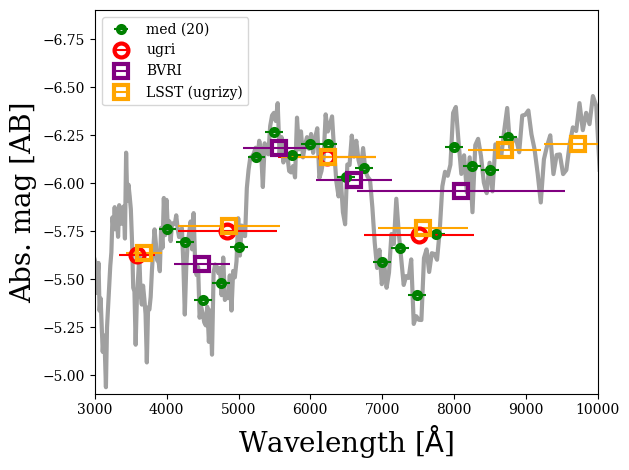

In [192]:
plt.plot(lam, abmag, c='grey', lw=3, alpha=0.75)
plt.errorbar(mlam, mmags.as_array().item(), xerr=mbdw/2, c='green', marker='.', mec='green', mfc='none', mew=3, ms=10, label=f'med ({len(mlam)})', ls='none')
plt.errorbar(slam, smags.as_array().item(), xerr=sbdw/2, c='red', marker='o', mec='red', mfc='none', mew=3, ms=10, label='ugri', ls='none')
plt.errorbar(jclam, jcmags.as_array().item(), xerr=jcbdw/2, c='purple', marker='s', mec='purple', mfc='none', mew=3, ms=10, label='BVRI', ls='none')
plt.errorbar(lsstlam, lsstmags.as_array().item(), xerr=lsstbdw/2, c='orange', marker='s', mec='orange', mfc='none', mew=3, ms=10, label='LSST (ugrizy)', ls='none')

plt.xlim([xl, xr])
plt.ylim([yu, yl])
plt.legend()

plt.xlabel('Wavelength'+r' [$\rm \AA$]')
plt.ylabel('Abs. mag [AB]')
plt.tight_layout()

- make result table

In [193]:
phtbl = Table()
phtbl['t'] = times*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Med']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag
	# phtbl[f"fnu_{filte}"] = 0.0
	# phtbl[f"fnu_{filte}"].format = '1.3f'

phtbl[:3]

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.136,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.149,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [194]:
for tt, t in enumerate(times):
	flam = knsptbl[anglecol][timestep*tt:timestep*(tt+1)]*(u.erg/u.second/u.Angstrom/(u.cm**2))
	fnu = convert_flam2fnu(flam, lam)
	abmag = fnu.to(u.ABmag)

	#	Med speclite
	mmags = meds.get_ab_magnitudes(flam, lam)
	#	SDSS speclite
	smags = sdss.get_ab_magnitudes(flam, lam)
	#	Johnson-Cousin speclite
	jcmags = jc.get_ab_magnitudes(flam, lam)

	for key in mmags.keys():
		medmag = mmags[key].item()
		# medfnu = (medmag*u.ABmag).to(u.erg/u.second/u.Hz/u.cm**2).value

		filte = key.split('-')[-1]
		phtbl[f"{filte}"][tt] = medmag+magoffset
		# phtbl[f"fnu_{filte}"][tt] = medfnu
phtbl


t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.125,-10.093,-10.023,-9.722,-9.811,-9.999,-10.466,-10.601,-10.477,-10.537,-10.534,-10.366,-10.409,-9.922,-9.995,-9.750,-10.064,-10.523,-10.422,-10.403,-10.572
0.136,-10.753,-10.718,-10.635,-10.663,-10.674,-10.910,-10.999,-10.919,-10.891,-10.890,-10.740,-10.828,-10.614,-10.585,-10.415,-10.521,-10.970,-10.767,-10.895,-10.974
0.149,-11.058,-11.038,-11.021,-11.036,-10.994,-11.052,-11.155,-11.035,-11.007,-11.039,-10.897,-11.008,-10.870,-10.818,-10.702,-10.765,-11.213,-11.014,-11.052,-11.132
0.162,-11.115,-11.105,-11.133,-11.104,-11.090,-11.154,-11.277,-11.176,-11.154,-11.214,-11.084,-11.203,-11.021,-10.951,-10.819,-10.953,-11.381,-11.214,-11.202,-11.300
0.177,-11.208,-11.212,-11.217,-11.190,-11.248,-11.389,-11.511,-11.408,-11.362,-11.408,-11.322,-11.418,-11.204,-11.151,-11.087,-11.144,-11.560,-11.408,-11.378,-11.529
0.193,-11.394,-11.358,-11.385,-11.368,-11.413,-11.579,-11.687,-11.597,-11.558,-11.590,-11.500,-11.576,-11.379,-11.370,-11.295,-11.321,-11.763,-11.583,-11.534,-11.679
0.21,-11.564,-11.527,-11.542,-11.542,-11.576,-11.729,-11.849,-11.770,-11.746,-11.760,-11.672,-11.769,-11.524,-11.506,-11.436,-11.482,-11.939,-11.737,-11.683,-11.804
0.229,-11.771,-11.718,-11.700,-11.725,-11.754,-11.905,-12.025,-11.950,-11.916,-11.925,-11.839,-11.933,-11.710,-11.645,-11.596,-11.657,-12.086,-11.881,-11.843,-11.928


In [195]:
phtbl.meta['classification'] = 'KN'
phtbl.meta['author'] = 'Wollaeger+21'
phtbl.meta['model'] = kncbtbl['model'][kk]
phtbl.meta['shape'] = kncbtbl['shape'][kk]
phtbl.meta['latitude'] = kncbtbl['latitude'][kk]
phtbl.meta['md'] = kncbtbl['md'][kk]
phtbl.meta['vd'] = kncbtbl['vd'][kk]
phtbl.meta['mw'] = kncbtbl['mw'][kk]
phtbl.meta['vw'] = kncbtbl['vw'][kk]
phtbl.meta['type'] = kncbtbl['type'][kk]

In [196]:
part = os.path.basename(knsp).split('_')

filtersetname = 'med'
part[-2] = f'angularbin{nangle}_synphot'
part[-1] = f'{filtersetname}.fits'

newfile = '_'.join(part)
print(newfile)


Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angularbincol3_synphot_med.fits


# Bulk iteration

In [197]:
path_model = '../3.table/kn_sim_cube_synphot'
if not os.path.exists(path_model): os.system(f"mkdir {path_model}")

In [198]:
def generate_synphot4kn(knsp, anglecol, inspeclite, filterlist, filtersetname, outname):
	knsptbl = Table.read(knsp)

	#	Wavelength & Time
	##	Wavelength
	lam = np.unique(knsptbl['lam'])*u.Angstrom
	timestep = len(lam)
	ntime = int(len(knsptbl)/timestep)
	##	Time
	times = np.array([float(knsptbl.meta['comments'][i].split('= ')[-1]) for i in range(len(knsptbl.meta['comments']))])
	times = times[:ntime]

	#	Table
	phtbl = Table()
	phtbl['t'] = times*u.day
	for filte in filterlist:
		phtbl[f"{filte}"] = 0.0
		phtbl[f"{filte}"].format = '1.3f'
		phtbl[f"{filte}"].unit = u.ABmag

	#	Synphot
	for tt, t in enumerate(times):
		flam = knsptbl[anglecol][timestep*tt:timestep*(tt+1)]*(u.erg/u.second/u.Angstrom/(u.cm**2))
		mags = inspeclite.get_ab_magnitudes(flam, lam)

		for key in mags.keys():
			mag = mags[key].item()
			filte = key.split('-')[-1]
			phtbl[f"{filte}"][tt] = mag+magoffset

	#	Meta data
	phtbl.meta['classification'] = 'KN'
	phtbl.meta['author'] = 'Wollaeger+21'
	phtbl.meta['model'] = kncbtbl['model'][kk]
	phtbl.meta['shape'] = kncbtbl['shape'][kk]
	phtbl.meta['latitude'] = kncbtbl['latitude'][kk]
	phtbl.meta['md'] = kncbtbl['md'][kk]
	phtbl.meta['vd'] = kncbtbl['vd'][kk]
	phtbl.meta['mw'] = kncbtbl['mw'][kk]
	phtbl.meta['vw'] = kncbtbl['vw'][kk]
	phtbl.meta['type'] = kncbtbl['type'][kk]

	#	Save the file
	phtbl.write(outname, format='fits', overwrite=True)

In [199]:
filtersetname = 'med'
path_save = f'{path_model}/{filtersetname}'
if not os.path.exists(path_save): os.system(f"mkdir {path_save}")

#	Input
filterlist = medfilterlist
inspeclite = meds

print('START SYNPHOT')

for kk, knsp0 in enumerate(kncbtbl['model']):
	#	Single KN spectrum Table
	knsp = f"../3.table/kn_sim_cube_lite/{knsp0}"
	print(f"[{kk+1}/{len(kncbtbl)}] {os.path.basename(knsp)}", end='\r')

	for nth, anglecol in enumerate(angledict.keys()):
		#	New file name
		part = os.path.basename(knsp).split('_')
		part[-2] = f'angularbin{nth+1:0>2}_synphot'
		part[-1] = f'{filtersetname}.fits'
		newfile = '_'.join(part)
		outname = f"{path_save}/{newfile}"
		#	Run
		generate_synphot4kn(knsp, anglecol, inspeclite, filterlist, filtersetname, outname)

START SYNPHOT


In [200]:
mags = sdss.get_ab_magnitudes(flam, lam)
mags.keys()

['broad-g', 'broad-i', 'broad-r', 'broad-u']

In [201]:
filtersetname = 'sdss.ugri'
path_save = f'{path_model}/{filtersetname}'
if not os.path.exists(path_save): os.system(f"mkdir {path_save}")

#	Input
# filterlist = [f"broad-{filte}" for filte in ['u', 'g', 'r', 'i']]
filterlist = ['u', 'g', 'r', 'i']
inspeclite = sdss

print('START SYNPHOT')

for kk, knsp0 in enumerate(kncbtbl['model']):
	#	Single KN spectrum Table
	knsp = f"../3.table/kn_sim_cube_lite/{knsp0}"
	print(f"[{kk+1}/{len(kncbtbl)}] {os.path.basename(knsp)}", end='\r')

	for nth, anglecol in enumerate(angledict.keys()):
		#	New file name
		part = os.path.basename(knsp).split('_')
		part[-2] = f'angularbin{nth+1:0>2}_synphot'
		part[-1] = f'{filtersetname}.fits'
		newfile = '_'.join(part)
		outname = f"{path_save}/{newfile}"
		#	Run
		generate_synphot4kn(knsp, anglecol, inspeclite, filterlist, filtersetname, outname)

START SYNPHOT


In [202]:
filtersetname = 'lsst.ugrizy'
path_save = f'{path_model}/{filtersetname}'
if not os.path.exists(path_save): os.system(f"mkdir {path_save}")

#	Input
# filterlist = [f"broad-{filte}" for filte in ['u', 'g', 'r', 'i']]
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
inspeclite = lsst

print('START SYNPHOT')

for kk, knsp0 in enumerate(kncbtbl['model']):
	#	Single KN spectrum Table
	knsp = f"../3.table/kn_sim_cube_lite/{knsp0}"
	print(f"[{kk+1}/{len(kncbtbl)}] {os.path.basename(knsp)}", end='\r')

	for nth, anglecol in enumerate(angledict.keys()):
		#	New file name
		part = os.path.basename(knsp).split('_')
		part[-2] = f'angularbin{nth+1:0>2}_synphot'
		part[-1] = f'{filtersetname}.fits'
		newfile = '_'.join(part)
		outname = f"{path_save}/{newfile}"
		#	Run
		generate_synphot4kn(knsp, anglecol, inspeclite, filterlist, filtersetname, outname)

START SYNPHOT


In [203]:
filtersetname = 'jc.BVRI'
path_save = f'{path_model}/{filtersetname}'
if not os.path.exists(path_save): os.system(f"mkdir {path_save}")

#	Input
filterlist = ['B', 'V', 'R', 'I']
inspeclite = jc

print('START SYNPHOT')

for kk, knsp0 in enumerate(kncbtbl['model']):
	#	Single KN spectrum Table
	knsp = f"../3.table/kn_sim_cube_lite/{knsp0}"
	print(f"[{kk+1}/{len(kncbtbl)}] {os.path.basename(knsp)}", end='\r')

	for nth, anglecol in enumerate(angledict.keys()):
		#	New file name
		part = os.path.basename(knsp).split('_')
		part[-2] = f'angularbin{nth+1:0>2}_synphot'
		part[-1] = f'{filtersetname}.fits'
		newfile = '_'.join(part)
		outname = f"{path_save}/{newfile}"
		#	Run
		generate_synphot4kn(knsp, anglecol, inspeclite, filterlist, filtersetname, outname)

START SYNPHOT
